In [19]:
import matplotlib.pyplot as plt
import torch
from torch.quasirandom import SobolEngine

import numpy as np
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints, normalize, unnormalize
from mpl_toolkits import mplot3d
# from matplotlib import cm
from alse.utils import read_excel
from alse.alse import alse
import copy
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

X, width, pow_cap, wth = read_excel("../test_data/8_4_data.xlsx",["P (W)", "V (mm/min)"], ["width (mm)", "powder_cap", "wth"])
bounds = torch.tensor([[900, 600], [2700, 1800]])
constraints = [("gt", 2.5), ("gt", 0.65), ("gt", 6)]

algo = alse(X, bounds, [width, pow_cap, wth], constraints)

algo.initialize_model(["reg", "reg", "reg"])

algo.next_test_points(3)

c:\Program Files\Python310\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


tensor([[1276.4072,  600.0000],
        [2545.9319,  828.1452],
        [2700.0000, 1033.2751]])

In [20]:
acq_val = algo.get_acq_val_grid(50, 2).round(decimals=4).detach()

c:\Program Files\Python310\lib\site-packages\gpytorch\distributions\multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


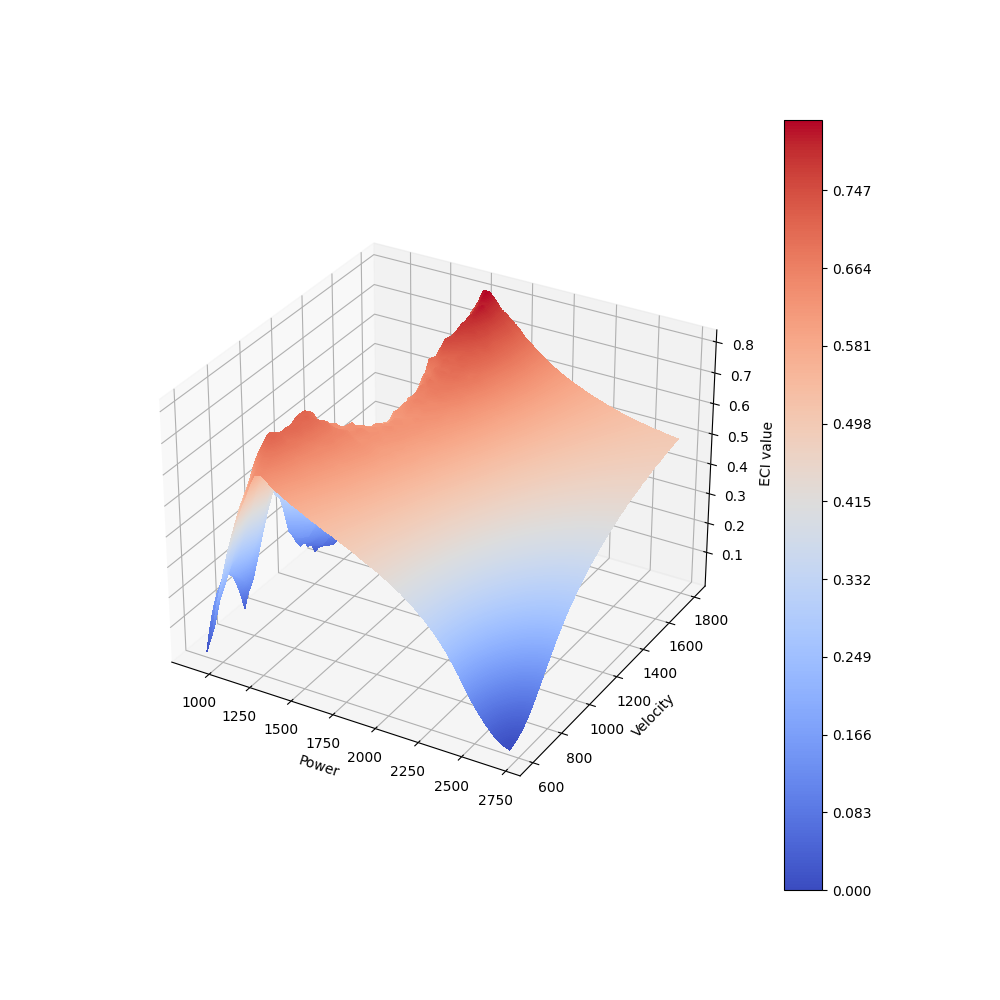

In [58]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

ax.set_xlabel("Power")
ax.set_ylabel("Velocity")
ax.set_zlabel("ECI value")
# img = ax.bar3d(X[:,0], X[:,1], 0, 20, 20, 1, shade=True)
img = ax.contourf3D(torch.linspace(900,2700,50),torch.linspace(600,1800,50),acq_val.reshape(50,50), 1000, cmap='coolwarm')

fig.colorbar(img)
plt.show()